https://keras.io/guides/transfer_learning/

An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset
(half way down on the web page)

In [16]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import logging, os

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../local_data/jheaton/"
DATA_PATH = "../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"class_09_2_keras_xfer_cv/"
os.system("mkdir -p " + OUTPUT_PATH)

0

In [17]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    data_dir=DATA_PATH,
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

INFO:absl:Load dataset info from ../../../../local_data/tfds/cats_vs_dogs/4.0.0
INFO:absl:Reusing dataset cats_vs_dogs (../../../../local_data/tfds/cats_vs_dogs/4.0.0)
INFO:absl:Constructing tf.data.Dataset cats_vs_dogs for split ['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'], from ../../../../local_data/tfds/cats_vs_dogs/4.0.0


Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


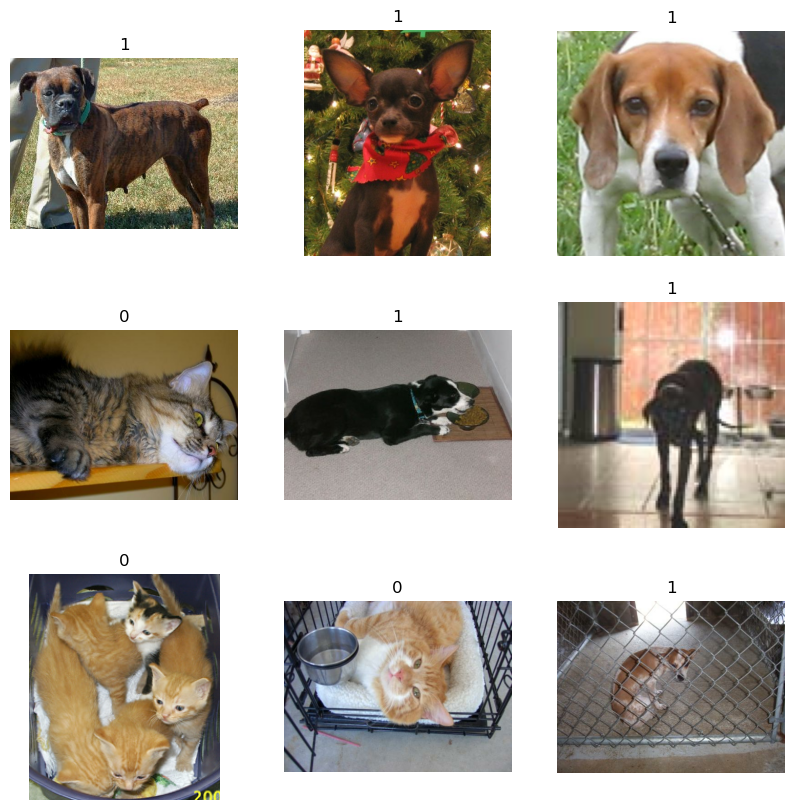

In [18]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [19]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [20]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [21]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

2025-06-30 20:41:10.651641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


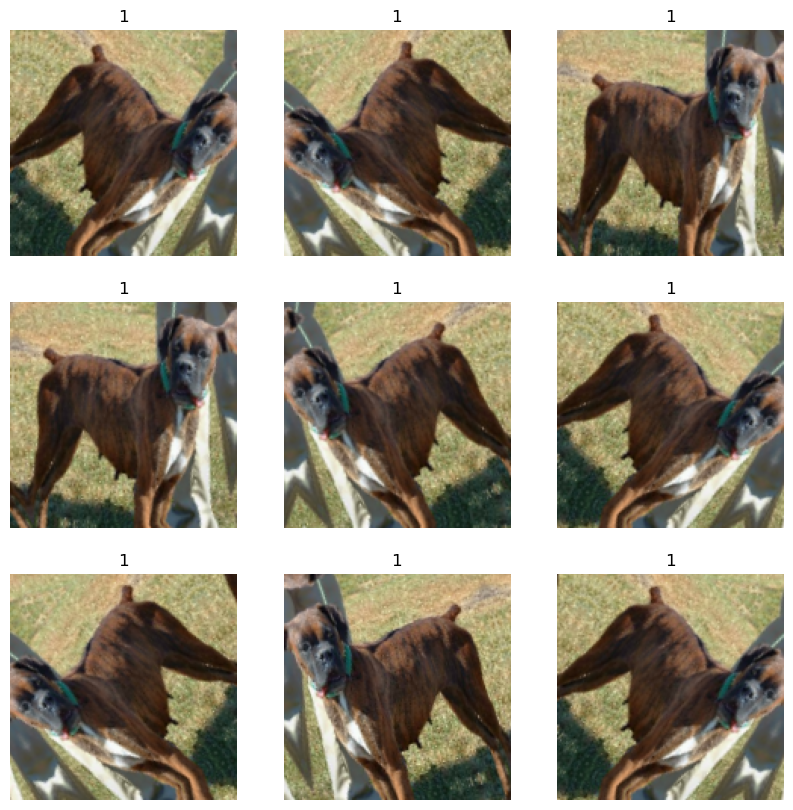

In [22]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0   

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
 73/146 [==============>...............] - ETA: 1:23 - loss: 0.2621 - binary_accuracy: 0.8729

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


131/146 [=========================>....] - ETA: 17s - loss: 0.2072 - binary_accuracy: 0.9033

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


138/146 [===========================>..] - ETA: 9s - loss: 0.2027 - binary_accuracy: 0.9055 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


140/146 [===========================>..] - ETA: 7s - loss: 0.2011 - binary_accuracy: 0.9064

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


146/146 [==============================] - ETA: 0s - loss: 0.1991 - binary_accuracy: 0.9079

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/146 [==============================] - 215s 1s/step - loss: 0.1991 - binary_accuracy: 0.9079 - val_loss: 0.0885 - val_binary_accuracy: 0.9665
Epoch 2/2
146/146 [==============================] - 213s 1s/step - loss: 0.1251 - binary_accuracy: 0.9487 - val_loss: 0.0811 - val_binary_accuracy: 0.9682


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0   

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)